In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
import random
%matplotlib inline
import glob
from osgeo import gdal
from tensorflow import keras
from osgeo import osr
import pandas as pd

In [40]:
from PIL import Image
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Conv2D, Input, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

In [41]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.metrics import Recall, Precision

In [42]:
train_image_dir = sorted(glob.glob("/fiverr/DATA/DATA/Image/*.tif"))
train_mask_dir = sorted(glob.glob("/fiverr/DATA/DATA/Label/*.tif"))
test_image_dir = sorted(glob.glob("fiverr/DATA/DATA/Image/*.tif"))
test_mask_dir = sorted(glob.glob("/fiverr/Test_labels/*.tif"))
# pred_image_dir = sorted(glob.glob("B:/datasets/predict_crosswalk/images/*.tif"))
# print(len(train_image_dir),len(test_image_dir),len(pred_image_dir))

In [43]:
len(train_image_dir)

33

**Converting the training files into numpy array**

In [44]:
#converting the training images in numpy array
train_xx = np.zeros((33,512,512,3))
train_yy = np.zeros((33,512,512))

for i, (img, mask) in enumerate(zip(train_image_dir,train_mask_dir)):
    img = gdal.Open(img).ReadAsArray().transpose()
    np_img=cv2.resize(img,(512,512))
    train_xx[i] = np_img

    mask = gdal.Open(mask).ReadAsArray().transpose()
    np_mask=cv2.resize(mask,(512,512))
    train_yy[i] = np_mask

**Converting the test files into numpy array**

In [45]:
#converting the test images in numpy array
test_xx = np.zeros((33,512,512,3))
test_yy = np.zeros((33,512,512))

for i, (img, mask) in enumerate(zip(test_image_dir,test_mask_dir)):
    img = gdal.Open(img).ReadAsArray().transpose()
    np_img=cv2.resize(img,(512,512))
    test_xx[i] = np_img

    mask = gdal.Open(mask).ReadAsArray().transpose()
    np_mask=cv2.resize(mask,(512,512))
    test_yy[i] = np_mask

**Converting the prediction image into numpy array**

In [ ]:
pred_xx = np.zeros((27,256,256,3))

for i, img in enumerate(pred_image_dir):
 img = gdal.Open(img).ReadAsArray().transpose()
 np_img=cv2.resize(img,(256,256))
 pred_xx[i] = np_img

In [21]:
num_train = len(train_xx)
print (num_train)

33


In [24]:
#random image number
img_num = random.randint(0, num_train-1)
img_num

11

**Plotting the image and mask**

In [38]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(train_xx[img_num,:,:,:].astype('uint8'))
plt.title("Image")
plt.subplot(1,2,2)
plt.imshow(train_yy[img_num,:,:].astype('uint8'))
plt.title("Mask")
#plt.show()

Text(0.5, 1.0, 'Mask')

**Model Preparation**

In [26]:
img_size = 512

# training attributes
batch_size = 64
epochs = 100


In [27]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [28]:


def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [29]:
input_img = Input((512, 512, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy", Recall(), Precision()])

In [30]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)              │ (None, 512, 512, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 512, 512, 16)      │             448 │ img[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 512, 512, 16)      │              64 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 512, 512, 16)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 512, 512, 16)      │           2,320 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 512, 512, 16)      │              64 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 512, 512, 16)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 256, 256, 16)      │               0 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256, 256, 16)      │               0 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 256, 256, 32)      │           4,640 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 256, 256, 32)      │             128 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 256, 256, 32)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 256, 256, 32)      │           9,248 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 256, 256, 32)      │             128 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 256, 256, 32)      │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 2,164,593 (8.26 MB)

 Trainable params: 2,161,649 (8.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

**Training the model**

In [31]:
History = model.fit(train_xx, train_yy, validation_data=(test_xx, test_yy), epochs=20, batch_size=5, verbose=1)
model.save('model_100_epochs.h5')

Epoch 1/20


C:\Users\regmi\.conda\envs\yogesh\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['img']. Received: the structure of inputs=*
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8509 - loss: nan - precision: 0.0076 - recall: 0.1557 - val_accuracy: 0.9366 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9914 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9366 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9912 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9366 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9927 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9366 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9895 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9366 - val_lo

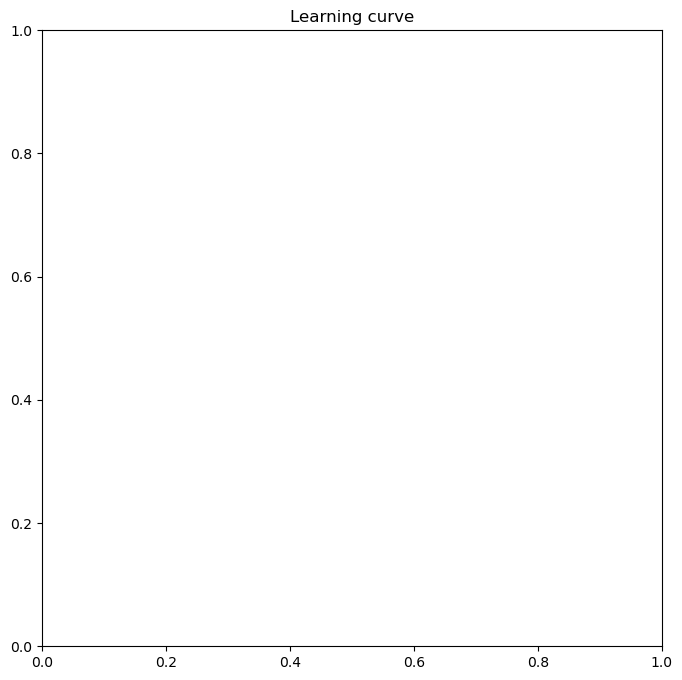

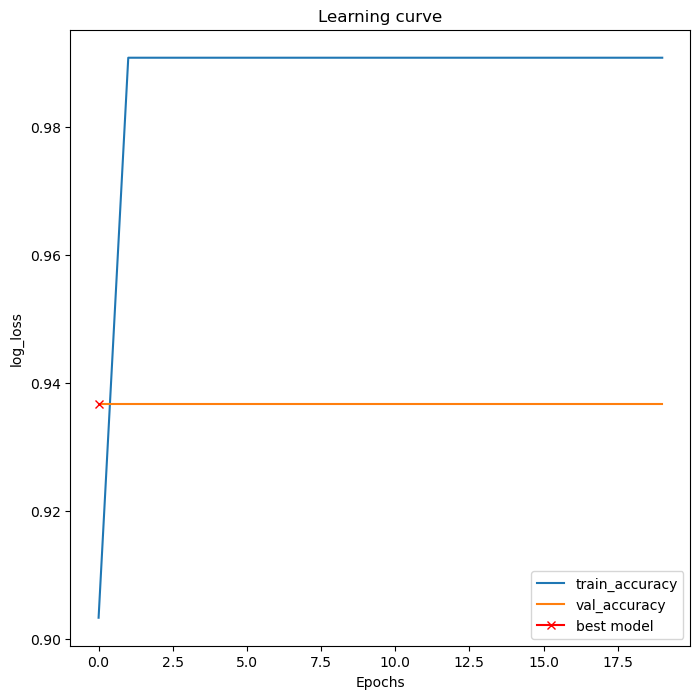

In [36]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(History.history["accuracy"], label="train_accuracy")
plt.plot(History.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmin(History.history["val_accuracy"]), np.min(History.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
plt.show()

In [37]:
import ee

ModuleNotFoundError: No module named 'ee'